In [1]:
import pandas as pd
import numpy as np
import os
import math
import sys
from datetime import datetime
import pdb
import argparse
from random import randint

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

from pyspark.sql import functions as sf
sys.path.append('/cluster/home/faltysm/source/2020_VolumeChallenge/common')
from spark_common import get_spark_session
from spark_common import get_included_subset

In [2]:
sns.set()

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
HIRID2_PATH="/cluster/work/grlab/clinical/hirid2/pg_db_export/"
PATIENT_STAY_PATH="/cluster/work/grlab/clinical/hirid2/research/faltysm/volume_challenge/patient_stay/2020-11-12"
NONBOLUS_PATH="/cluster/work/grlab/clinical/hirid2/research/faltysm/volume_challenge/gap_closed/non_bolus/2020-12-05"
TIME_PERIOD_LENGHT = 300
BOLUS_LIMIT = 250
BOLUS_WINDOW = 1800
ISOLATED_BOLUS_END_MARGIN = 3600
ISOLATED_BOLUS_START_MARGIN = 3600
CLOSE_GAP = True

In [9]:
def get_patient_volrec(patientid, df_pharmarec, volume_pharma_ids=[1000030,1000739,1000866]):
    df_volumes = df_pharmarec.where(sf.col('pharmaid').isin(volume_pharma_ids))
    df_volumes = df_volumes.where('patientid=' + str(patientid))
    return df_volumes

In [10]:
def get_stay_information(patientid, df_stay_data):
    #reference point for relative dataframe
    stay = df_stay_data.where(f'patientid={patientid}').toPandas()
    rel_referencepoint = stay.rel_referencepoint[0]
    lenght_of_stay = stay.lenght_of_stay[0]
    lenght_of_stay_period_count = math.ceil(lenght_of_stay / TIME_PERIOD_LENGHT)

    return rel_referencepoint, lenght_of_stay, lenght_of_stay_period_count

In [11]:
def get_rastered_infusion(df_infusions, infusionid, rel_referencepoint, lenght_of_stay, lenght_of_stay_period_count):
    infusions = df_infusions.where('infusionid=' + str(infusionid)).sort('datetime').select('datetime', 'givendose', 'cumuldose', 'rate', 'status','pharmaid').toPandas()

    infusion_periods = []
    for i in range(0, infusions.shape[0]-1): #-1: last row marks only the end
        row_start = int((infusions.iloc[i,0] - rel_referencepoint).total_seconds())
        if row_start < 0:
            row_start = 0
            print ("rowstart")
        row_end = int((infusions.iloc[i+1,0] - rel_referencepoint).total_seconds())-1  #ends one second before the start of the next interval
        if row_end < 0:
            print ("rowend before entry")  #currently these are not added see below
        if row_end > lenght_of_stay:
            row_end = lenght_of_stay
            print ("rowend")
        given_dose = infusions.iloc[i+1,1]
        period_lenght = (row_end - row_start)
        if given_dose > 0 and given_dose <= 1000 and row_end>0 and period_lenght>0:
            rate_sec = given_dose/period_lenght
            infusion_periods.append([row_start, row_end, given_dose, period_lenght, rate_sec])
    
    rastered_infusion_periods = []
    for infusion_period in infusion_periods:
        starting_edge, trailing_edge = [], []

        first_time_intervall = int(infusion_period[0] / TIME_PERIOD_LENGHT)    #partial intervall inculded
        period_lenght_count = math.ceil(infusion_period[3] / TIME_PERIOD_LENGHT)
        leading_zeros = [0] * first_time_intervall
        if period_lenght_count>1:
            if (infusion_period[0] % TIME_PERIOD_LENGHT) != 0:
                starting_edge = [(TIME_PERIOD_LENGHT - (infusion_period[0] % TIME_PERIOD_LENGHT)) * infusion_period[4]] #partial time intervall with infusion
            if (infusion_period[1] % TIME_PERIOD_LENGHT) != 0:
                trailing_edge = [(infusion_period[1] % TIME_PERIOD_LENGHT) * infusion_period[4]]
        else:
            starting_edge = [infusion_period[3] * infusion_period[4]]  #period shorter than one time intervall
        main_block_lenght = period_lenght_count - len(starting_edge) - len(trailing_edge)
        main_block = [infusion_period[4]*TIME_PERIOD_LENGHT] * main_block_lenght
        trailing_zeros = [0] * (lenght_of_stay_period_count - len(leading_zeros) - period_lenght_count)
        rastered_infusion_period = leading_zeros + starting_edge + main_block + trailing_edge + trailing_zeros
        rastered_infusion_periods.append(np.array(rastered_infusion_period))
        
    rastered_infusion = np.add.reduce(rastered_infusion_periods)
    infusion_source = infusions.iloc[0,5]
    return rastered_infusion, infusion_source 

In [12]:
def enlarge_bolus(rastered_ringer, bolus, start_of_bolus, end_of_bolus):
    #look for bolus enlargment direction
    for j in range(1,int(BOLUS_WINDOW / TIME_PERIOD_LENGHT)):
        for k in range(0,j+1):
            tmp_start_of_bolus = max(start_of_bolus - (j - k),0)
            tmp_end_of_bolus = min(end_of_bolus + k, len(bolus)-1)
            
            tmp_total_fluid = np.sum(rastered_ringer[tmp_start_of_bolus:tmp_end_of_bolus+1])
            if round(tmp_total_fluid) >= BOLUS_LIMIT:
                if k>0:
                    bolus[min(end_of_bolus + 1, len(bolus)-1)] = True
                    print (f"Bolus enlarged - end; current end: {end_of_bolus} new end:{end_of_bolus+1}")
                else:
                    bolus[max(start_of_bolus - 1,0)] = True
                    print (f"Bolus enlarged - beginning; current start: {start_of_bolus} new start:{start_of_bolus-1}")
                return
        if j==int(BOLUS_WINDOW / TIME_PERIOD_LENGHT)-1:
            raise ValueError("ERROR NO SOLUTION FOUND TO BOLUS ENLARGMENT")

In [13]:
def process_rastered_infusions_into_boluses(rastered_ringer): 
    #define bolus region by calculating bolus regions by cummulative sum
    cumsum_array = np.cumsum(rastered_ringer)
    avg_volume_h = cumsum_array[-1] / len(cumsum_array) * 3600 / TIME_PERIOD_LENGHT
    bolus_region = np.zeros(len(rastered_ringer), dtype=bool)
    for i in range(0, len(rastered_ringer)):
        upperindex = min(i+5, len(rastered_ringer)-1)
        previous_cumsum_value = 0    #this step is required for the first value of the stay
        if i > 0:
            previous_cumsum_value = cumsum_array[i-1]
        if cumsum_array[upperindex] - previous_cumsum_value >= 250:  #the i-th value contains the fluid given in the i-th period -> minus value at i-1
            bolus_region[i:upperindex+1] = True
    
    #bolus where current rate > desired average rate
    bolus = (rastered_ringer > BOLUS_LIMIT/BOLUS_WINDOW*TIME_PERIOD_LENGHT)&bolus_region

    #bolus growth if current "bolus" selection is not large enough.
    check_completed = False
    while check_completed == False:
        start_of_bolus = 0
        check_completed = True
        for i in range(1, len(bolus)):
            if bolus[i] == True and bolus[i-1] == False:
                start_of_bolus = i
            if bolus[i] == True and (i == (len(bolus) - 1) or bolus[i+1] == False):
                end_of_bolus = i
                total_fluid = np.sum(rastered_ringer[start_of_bolus:end_of_bolus+1])
                if round(total_fluid) < BOLUS_LIMIT:
                    print (f"small bolus: {total_fluid} start at {start_of_bolus} end at {end_of_bolus}")
                    check_completed = False
                    enlarge_bolus(rastered_ringer, bolus, start_of_bolus, end_of_bolus)
                    break
    
    #close 5min gaps
    if CLOSE_GAP:
        for i in range(len(bolus)):
            if i < len(bolus)-2 and bolus[i] == True and bolus[i+1] == False and bolus[i+2] == True:
                #close 5min gap
                print("gab closed")
                bolus[i+1] = True
    
    window_count_end_margin = int(ISOLATED_BOLUS_END_MARGIN / TIME_PERIOD_LENGHT)
    window_count_start_margin = int(ISOLATED_BOLUS_START_MARGIN / TIME_PERIOD_LENGHT)
    isolated_bolus = bolus.copy() 

    for i in range(len(bolus)):
        #last window of bolus, check if next x are all false, whereas x depends on endmargin and window size
        if i != len(bolus)-1 and bolus[i] == True and bolus[i+1] == False:
            for j in range(min(window_count_end_margin,len(bolus)-i-1)):
                if bolus[i+1+j] == True:  #an other bolus exists
                    #delete current bolus
                    k = i
                    print ("post condition: bolus deleted at " + str(k))
                    while bolus[k] == True and k >= 0:
                        isolated_bolus[k] = False
                        k -= 1

        #first window of a bolus, check if x before are false
        if i != 0 and bolus[i] == True and bolus[i-1] == False:
            for j in range(min(window_count_start_margin,i)):
                if bolus[i-1-j] == True:  #an other bolus exists
                    #delete current bolus
                    k = i
                    print ("prä condition: bolus deleted at " + str(k))
                    while k < len(bolus) and bolus[k] == True:
                        isolated_bolus[k] = False 
                        k += 1
                        
    #delete boluses reaching into first 1h
    for j in range(min(window_count_start_margin,len(isolated_bolus))):
        k=0
        while isolated_bolus[(j+k)] == True:
            print ("start bolus")
            isolated_bolus[(j+k)] = False
            if j+k+1 < len(isolated_bolus):
                k += 1

    #delete boluses reaching into last 1h
    for j in range(min(window_count_end_margin+1,len(isolated_bolus)-1)):
        k=0
        while isolated_bolus[-(j+k)] == True:
            print ("end bolus")
            isolated_bolus[-(j+k)] = False
            k += 1

    return bolus_region, bolus, isolated_bolus, avg_volume_h

In [14]:
def calculate_previous_fluid(rastered_ringer, start_of_bolus, duration_hours):
    duration_timeslices = int(duration_hours * 3600 / TIME_PERIOD_LENGHT)
    previous_fluid = 0
    start_of_fluid_period = max(0, start_of_bolus - duration_timeslices)
    if start_of_bolus > 0:
        previous_fluid = np.sum(rastered_ringer[start_of_fluid_period:start_of_bolus])
    
    return previous_fluid

In [15]:
def detect_boluses_and_describe(patientid, bolus_collection, rastered_ringer):
    #result stores
    df_boluses = pd.DataFrame(columns=['patientid', 'bolusid', 'startindex', 'endindex','lenght','fluidamount', 'previous_fluid_total', 'previous_fluid_30min', 'previous_fluid_1h', 'previous_fluid_2h'])

    start_of_bolus = 0
    bolus_count = 0
    #search for boluses
    for i in range(0, len(bolus_collection)):
        if i > 0:
            if bolus_collection[i] == True and bolus_collection[i-1] == False:
                start_of_bolus = i
        else:
            if bolus_collection[i] == True:
                start_of_bolus = i
        if bolus_collection[i] == True and (i == len(bolus_collection)-1 or bolus_collection[i+1] == False):
            end_of_bolus = i
            bolus_count += 1
            bolus_lenght = end_of_bolus-start_of_bolus+1
            total_fluid = round(np.sum(rastered_ringer[start_of_bolus:end_of_bolus+1]))
            previous_total_fluid = calculate_previous_fluid(rastered_ringer, start_of_bolus, 8640)
            previous_2h_fluid = calculate_previous_fluid(rastered_ringer, start_of_bolus, 2)
            previous_1h_fluid = calculate_previous_fluid(rastered_ringer, start_of_bolus, 1)
            previous_30min_fluid = calculate_previous_fluid(rastered_ringer, start_of_bolus, 0.5)
            df_boluses=df_boluses.append(pd.Series([patientid, bolus_count, start_of_bolus, end_of_bolus,bolus_lenght, total_fluid, previous_total_fluid, previous_30min_fluid, previous_1h_fluid, previous_2h_fluid], index=df_boluses.columns), ignore_index=True)
    
    return df_boluses

In [16]:
def process_patient(patientid, df_stay_data, df_pharmarec):
    print (patientid)
    rel_referencepoint, lenght_of_stay, lenght_of_stay_period_count = get_stay_information(patientid, df_stay_data)
    
    #get infusion data
    df_infusions = get_patient_volrec(patientid, df_pharmarec)

    #process infusions of patient to rastered infusions
    rastered_infusions = []
    infusion_sources = []
    for infusionid in [int(row.infusionid) for row in df_infusions.select('infusionid').distinct().sort('infusionid').collect()]:
        rastered_infusion, infusion_source = get_rastered_infusion(df_infusions, infusionid, rel_referencepoint, lenght_of_stay, lenght_of_stay_period_count)

        if isinstance(rastered_infusion, np.ndarray):
            rastered_infusions.append(rastered_infusion)
            infusion_sources.append(infusion_source)
        else:
            print ("DEBUG: " + str(infusionid))

    #bolus calculations 
    bolus_region = []
    bolus = []
    isolated_bolus = []
    rastered_ringer = []
    avg_volume_h = 0
    if len(rastered_infusions)>0:
        rastered_ringer = np.add.reduce(rastered_infusions)
        bolus_region, bolus, isolated_bolus, avg_volume_h = process_rastered_infusions_into_boluses(rastered_ringer)
                                
    #bolus detection and description
    df_boluses = detect_boluses_and_describe(patientid, bolus, rastered_ringer)
    df_isolated_boluses = detect_boluses_and_describe(patientid, isolated_bolus, rastered_ringer)
            
    return rastered_infusions, rastered_ringer, infusion_sources, bolus_region, bolus, isolated_bolus, df_boluses, df_isolated_boluses, avg_volume_h

In [17]:
spark = get_spark_session(8, 1024, 64)

In [18]:
def get_ringer_plot(patientid, display_nonbolus, display_region, display_observation_period, dispay_sources):
    df_pharmarec = spark.read.parquet(os.path.join(HIRID2_PATH, 'p_pharmarec')).where('patientid >= ' + str(patientid) + ' and patientid <= ' + str(patientid)).cache()
    df_stay_data = spark.read.parquet(PATIENT_STAY_PATH).where('patientid >= ' + str(patientid) + ' and patientid <= ' + str(patientid)).cache()
    
    if display_nonbolus:
        df_nonbolus = spark.read.parquet(NONBOLUS_PATH).where('patientid >= ' + str(patientid) + ' and patientid <= ' + str(patientid)).cache().toPandas()
    
    if df_stay_data.count() > 0:
        rastered_infusions, rastered_ringer, infusion_sources, bolus_region, bolus, isolated_bolus, df_boluses, df_isolated_boluses, avg_fluid_h = process_patient(patientid, df_stay_data, df_pharmarec)
        print(f'avg fluid:{avg_fluid_h}')
        
        if display_region:
            if display_nonbolus:
                dims = (20, 12)
                fig, axs = plt.subplots(6, 1, gridspec_kw={'height_ratios': [6, 1, 0.5,0.5,1,1]}, figsize=dims, sharex=True)
            else:
                dims = (20, 10)
                fig, axs = plt.subplots(5, 1, gridspec_kw={'height_ratios': [6, 1, 0.5,0.5,1]}, figsize=dims, sharex=True)
        else:
            if display_nonbolus:
                dims = (20, 10)
                fig, axs = plt.subplots(5, 1, gridspec_kw={'height_ratios': [6, 1,0.5,1,1]}, figsize=dims, sharex=True)
            else:
                dims = (20, 8)
                fig, axs = plt.subplots(4, 1, gridspec_kw={'height_ratios': [6, 1,0.5,1]}, figsize=dims, sharex=True)

        plot_list = rastered_infusions + [rastered_ringer]
        if len(rastered_infusions) > 0:
            if not dispay_sources:
                infusion_sources = []
                for idx in range(1, len(rastered_infusions)+1):
                    infusion_sources.append(f'Infusion #{idx}')
            
            sns.heatmap(np.array(rastered_infusions)*12, cmap="YlGnBu",ax=axs[0],mask=(np.array(rastered_infusions)==0),yticklabels=infusion_sources)
            sns.heatmap([rastered_ringer*12], cmap="YlGnBu",ax=axs[1],yticklabels=['Total'], mask=(np.array([rastered_ringer])==0))
            cmap = sns.light_palette("#306bcc", as_cmap=True)
            index = 1
            if display_region:
                index=2
                sns.heatmap([bolus_region], cmap=cmap,ax=axs[2], vmin=0, vmax=1,yticklabels=['Region'])
            sns.heatmap([bolus], cmap=cmap,ax=axs[index + 1], vmin=0, vmax=1,yticklabels=['Bolus'])
            
            cmap = sns.light_palette("#306bcc", as_cmap=True)
            
            if display_observation_period:
                isolated_bolus = isolated_bolus.astype(float) 
                for i in range(0, len(isolated_bolus)-1):
                    if isolated_bolus[i] == 1 and isolated_bolus[i-1] == 0:  #first point of bolus
                        isolated_bolus[i-12:i] = 0.5
                    if isolated_bolus[i] == 1 and isolated_bolus[i+1] == 0:  #last point of bolus
                        isolated_bolus[i + 1:i + 13] = 0.5
                    
            sns.heatmap([isolated_bolus], cmap=cmap,ax=axs[index + 2], vmin=0, vmax=1,yticklabels=['Isolated'])
            
            if display_nonbolus:
                non_bolus = np.zeros(len(bolus), dtype=float)
                for idx, row in df_nonbolus.iterrows():
                    print(f'{int(row.startindex)}-{int(row.endindex+1)}')
                    non_bolus[int(row.startindex):int(row.endindex+1)] = True
                    
                for i in range(0, len(isolated_bolus)-1):
                    if non_bolus[i] == 1 and non_bolus[i-1] == 0:  #first point of bolus
                        non_bolus[i-12:i] = 0.5
                    if non_bolus[i] == 1 and non_bolus[i+1] == 0:  #last point of bolus
                        non_bolus[i + 1:i + 12] = 0.5
                
                cmap = sns.light_palette("#0e6b0e", as_cmap=True)
                sns.heatmap([non_bolus], cmap=cmap,ax=axs[index + 3], vmin=0, vmax=1,yticklabels=['Control'])   
        
        plt.subplots_adjust(hspace=0.1)
        #plt.xticks(np.arange(0, len(bolus), 12.0))
        axs[0].set_title("Ringer for Patient " + str(patientid))
        return fig.tight_layout(),df_boluses, df_isolated_boluses, rastered_ringer
    return None, None, None, None

96916
gab closed
post condition: bolus deleted at 104
post condition: bolus deleted at 104
post condition: bolus deleted at 104
post condition: bolus deleted at 104
post condition: bolus deleted at 104
post condition: bolus deleted at 104
post condition: bolus deleted at 104
prä condition: bolus deleted at 110
prä condition: bolus deleted at 110
prä condition: bolus deleted at 110
prä condition: bolus deleted at 110
prä condition: bolus deleted at 110
prä condition: bolus deleted at 110
prä condition: bolus deleted at 110
post condition: bolus deleted at 118
post condition: bolus deleted at 118
post condition: bolus deleted at 118
post condition: bolus deleted at 118
post condition: bolus deleted at 118
post condition: bolus deleted at 118
post condition: bolus deleted at 118
post condition: bolus deleted at 118
prä condition: bolus deleted at 123
prä condition: bolus deleted at 123
prä condition: bolus deleted at 123
prä condition: bolus deleted at 123
prä condition: bolus deleted at 

,patientid,bolusid,startindex,endindex,lenght,fluidamount,previous_fluid_total,previous_fluid_30min,previous_fluid_1h,previous_fluid_2h
0,96916.0,1.0,33.0,35.0,3.0,278.0,22.210636,22.210636,22.210636,22.210636
1,96916.0,2.0,71.0,71.0,1.0,281.0,960.724670,242.000538,469.346599,565.567320


,patientid,bolusid,startindex,endindex,lenght,fluidamount,previous_fluid_total,previous_fluid_30min,previous_fluid_1h,previous_fluid_2h
0,96916.0,1.0,33.0,35.0,3.0,278.0,22.210636,22.210636,22.210636,22.210636
1,96916.0,2.0,71.0,71.0,1.0,281.0,960.724670,242.000538,469.346599,565.567320
2,96916.0,3.0,85.0,104.0,20.0,1385.0,1529.289941,94.910707,269.396942,971.899501
3,96916.0,4.0,110.0,118.0,9.0,417.0,2916.133321,60.174587,521.831422,1327.295940
4,96916.0,5.0,123.0,139.0,17.0,1120.0,3431.401591,191.094143,468.957681,960.156887


[  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.          22.21063608  93.84775808  93.84775808
  90.40998513   8.62192844   8.62192844   8.62192844   8.62192844
   8.62192844   8.62192844   8.62192844   8.62192844   8.62192844
   8.62192844   8.62192844   8.62192844   8.62192844   8.62192844
   8.62192844   8.62192844   8.62192844   8.62192844   8.62192844
   8.62192844   8.62192844   8.62192844   1.37950855  25.67894595
  40.33342296  40.33342296  40.33342296  40.33342296  40.33342296
  40.33342296  40.33342296  40.33342296  40.33342296  40.33342296
  40.33342296 280.65340145  18.51492827  29.08103916  29.08103916
  29.08103916  29.08103916  29.08103916  29.08103916  29.0

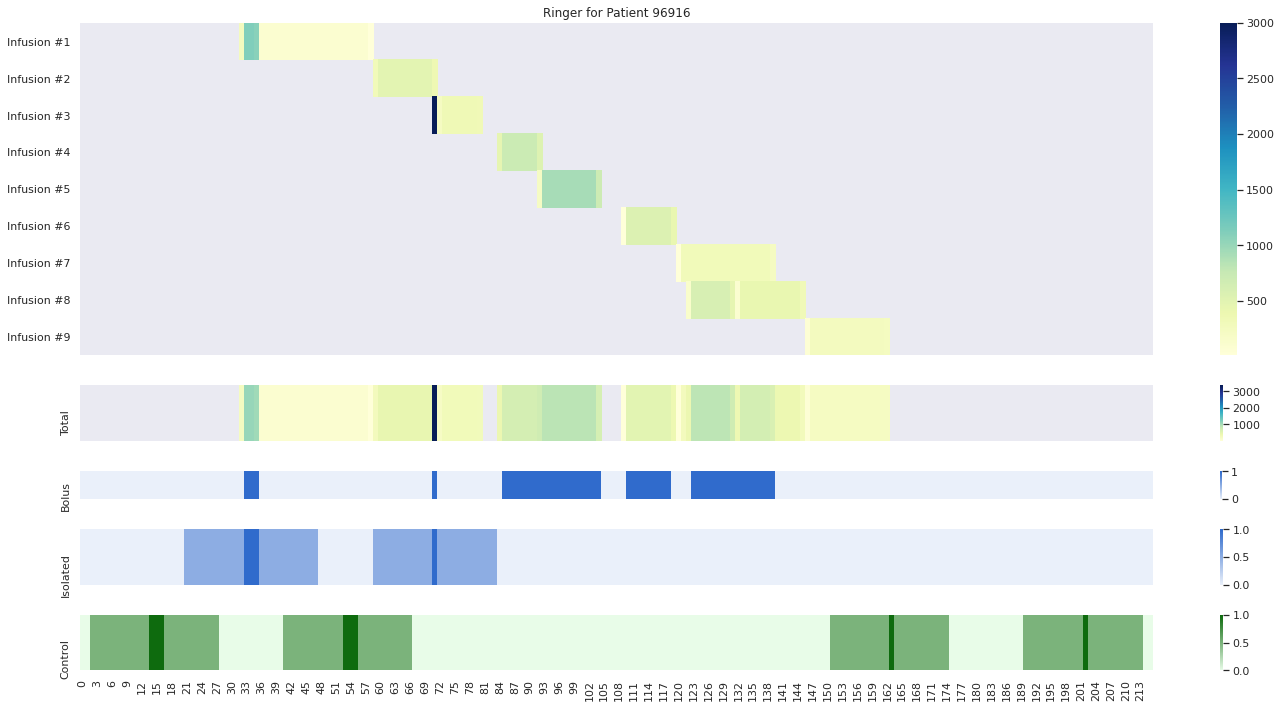

In [19]:
CLOSE_GAP = True
plot, df_boluses_iso, df_boluses, rastered_ringer = get_ringer_plot(96916, True, False, True, False)
display(df_boluses)
display(df_boluses_iso)
print(rastered_ringer)

with PdfPages('supp_fig2_test.pdf') as pdf:
    f = pdf.savefig(plot)